***Install Dependencies***



In [1]:
!pip install -q transformers accelerate datasets scikit-learn matplotlib seaborn arabic-reshaper python-bidi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 41.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.7 MB/s eta 0:00:000:00:0100:01
ERROR: pip's de

***Imports***

In [ ]:
import re
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding

#hardware check - should be cude/GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} (Must be 'cuda')")

#camelbert-ca model
model_name = "CAMeL-Lab/bert-base-arabic-camelbert-ca"
print(f" Model Selected: {model_name}")

2025-12-03 07:26:24.373260: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764746784.576395      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764746784.637680      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Using device: cuda (Must be 'cuda')
 Model Selected: CAMeL-Lab/bert-base-arabic-camelbert-ca


***Cleaning Function***

In [ ]:
def advanced_clean(text):
    text = str(text)
    #remove Tashkeel (Diacritics)
    text = re.sub(r'[\u064B-\u065F]', '', text)
    #remove Tatweel (Elongation)
    text = re.sub(r'ـ', '', text)
    #normalize Alef letter
    text = re.sub(r'[إأآ]', 'ا', text)
    #normalize Taa Marbuta letter
    text = re.sub(r'ة', 'ه', text)
    #normalize Yaa letter
    text = re.sub(r'ى', 'ي', text)
    #remove Numbers
    text = re.sub(r'\d+', '', text)
    #remove Punctuation
    text = re.sub(r'[^\w\s]', '', text)
    #remove extra Whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

***Load Dataset***

In [4]:
print("⬇ Loading dataset...")
dataset = load_dataset("omkarthawakar/FannOrFlop")
df = dataset["train"].to_pandas()[["poem_verses", "era"]].dropna()

print("Applying Advanced Cleaning...")

print(f"Before: {df['poem_verses'].iloc[0][:50]}...")

df['poem_verses'] = df['poem_verses'].apply(advanced_clean)

print(f"After:  {df['poem_verses'].iloc[0][:50]}...")

⬇ Loading dataset...


README.md: 0.00B [00:00, ?B/s]

dataset.json:   0%|          | 0.00/99.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6984 [00:00<?, ? examples/s]

Applying Advanced Cleaning...
Before: 1

حَيّـاكُمُ اللَـهُ أَحيـوا العِلمَ وَالأَدَبا

...
After:  حياكم الله احيوا العلم والادبا ان تنشروا العلم ينش...


***Split & Encode Labels***



In [ ]:
#encode labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["era"])
label2id = {label: idx for idx, label in enumerate(le.classes_)}
id2label = {idx: label for label, idx in label2id.items()}

# Split
print("Splitting data...")
train_df, val_df = train_test_split(
    df,
    test_size = 0.2, #this goes to val_df
    stratify = df["label"], #ensure class distribution is preserved
    random_state = 42 #stability so every time we run code we get same split
)

print(f"Original Train Size: {len(train_df)}")
print(f"Validation Size:     {len(val_df)}")

Splitting data...
Original Train Size: 5587
Validation Size:     1397


***Balance Data (Upsampling)***

In [ ]:
print("Balancing Training Data...")
max_size = train_df['label'].value_counts().max() #counting samples in each class

balanced_fragments = []
for label_id in train_df['label'].unique(): #looping over each class
    class_df = train_df[train_df['label'] == label_id]
    resampled_df = resample(class_df,
    replace = True,
    n_samples = max_size,
    random_state = 42)
    balanced_fragments.append(resampled_df)

train_df_balanced = pd.concat(balanced_fragments)
train_df_balanced = train_df_balanced.sample(frac = 1, random_state = 42).reset_index(drop = True)

print(f"Balanced Train Size: {len(train_df_balanced)} (All classes = {max_size})")

Balancing Training Data...
Balanced Train Size: 22488 (All classes = 1874)


In [ ]:
print(f"Loading Tokenizer: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(
        examples["poem_verses"], #row Arabic poem text
        truncation = True, #if poem logner than 512 > cut
        max_length = 512,
    )

print("Tokenizing data...")

train_ds = Dataset.from_pandas(train_df_balanced).map(preprocess_function, batched = True)
val_ds = Dataset.from_pandas(val_df).map(preprocess_function, batched = True)

Loading Tokenizer: CAMeL-Lab/bert-base-arabic-camelbert-ca


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/468 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenizing data...


Map:   0%|          | 0/22488 [00:00<?, ? examples/s]

Map:   0%|          | 0/1397 [00:00<?, ? examples/s]

***Initialize Model***

In [ ]:
print("Initializing Model...")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels = len(le.classes_), #12 classes
    id2label = id2label, #map classes to num IDs
    label2id = label2id, #map num IDs to classes
).to(device)

Initializing Model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-ca and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***Training Setup***

In [ ]:
#computing the metrics: Accuracy & F1 Score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted"),
    }

training_args = TrainingArguments(
    output_dir="./camelbert_ultimate_results",#path where checkpoints and logs are saved

    #evaluation strategy - each happens per epoch
    eval_strategy = "epoch",
    save_strategy = "epoch",
    logging_strategy = "epoch",

    #optimization tuning
    learning_rate = 2e-5, #common learning rate for BERT 
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    gradient_accumulation_steps = 2, 

    #scheduler & epochs
    num_train_epochs = 10, #10 passes over training data
    lr_scheduler_type = "cosine",
    warmup_ratio = 0.1, #10% of training steps increse lineraly to lr ,, stable at early point

    weight_decay = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = "accuracy",
    report_to = "none"
)

trainer = Trainer(
    model = model, #CamelBERT
    args = training_args, #all hyperparameters and strategies written above :)
    train_dataset = train_ds, #tokanized dataset
    eval_dataset = val_ds, #tokanized dataset
    tokenizer = tokenizer,
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer),#pad each batch to max length dynamically
    compute_metrics = compute_metrics, #compute metrics after each eval
)

/tmp/ipykernel_47/3567563889.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


***Train Model***

In [14]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.127200,1.460274,0.651396,0.654072
2,0.066500,1.665009,0.664281,0.667534
3,0.050500,1.804725,0.660702,0.652593
4,0.027900,2.029323,0.668576,0.667176
5,0.013500,2.393837,0.667144,0.666060
6,0.005100,2.233915,0.686471,0.683629
7,0.003300,2.113332,0.691482,0.687030
8,0.000800,2.169545,0.695061,0.695093
9,0.000400,2.157823,0.705798,0.703064
10,0.000300,2.161002,0.705082,0.702272


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

TrainOutput(global_step=3520, training_loss=0.029545270370065487, metrics={'train_runtime': 11538.7429, 'train_samples_per_second': 19.489, 'train_steps_per_second': 0.305, 'total_flos': 5.91250467068928e+16, 'train_loss': 0.029545270370065487, 'epoch': 10.0})

***Evaluate and Visualize***


 Final Report :


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


                   precision    recall  f1-score   support

  الدولة الايوبية      0.595     0.602     0.599        83
  الدولة الفاطمية      0.653     0.598     0.624        82
 الدولة المملوكية      0.667     0.707     0.686        82
الشعراء المخضرمون      0.533     0.526     0.530        76
     العصر الأموي      0.698     0.789     0.741       114
   العصر الإسلامي      0.585     0.407     0.480        59
     العصر الحديث      0.887     0.729     0.800       140
    العصر العباسي      0.750     0.831     0.788       468
   العصر العثماني      0.768     0.662     0.711        65
  المغرب والأندلس      0.703     0.584     0.638        89
 عصر بين الدولتين      0.672     0.672     0.672        64
      قبل الإسلام      0.590     0.613     0.601        75

         accuracy                          0.706      1397
        macro avg      0.675     0.643     0.656      1397
     weighted avg      0.706     0.706     0.703      1397



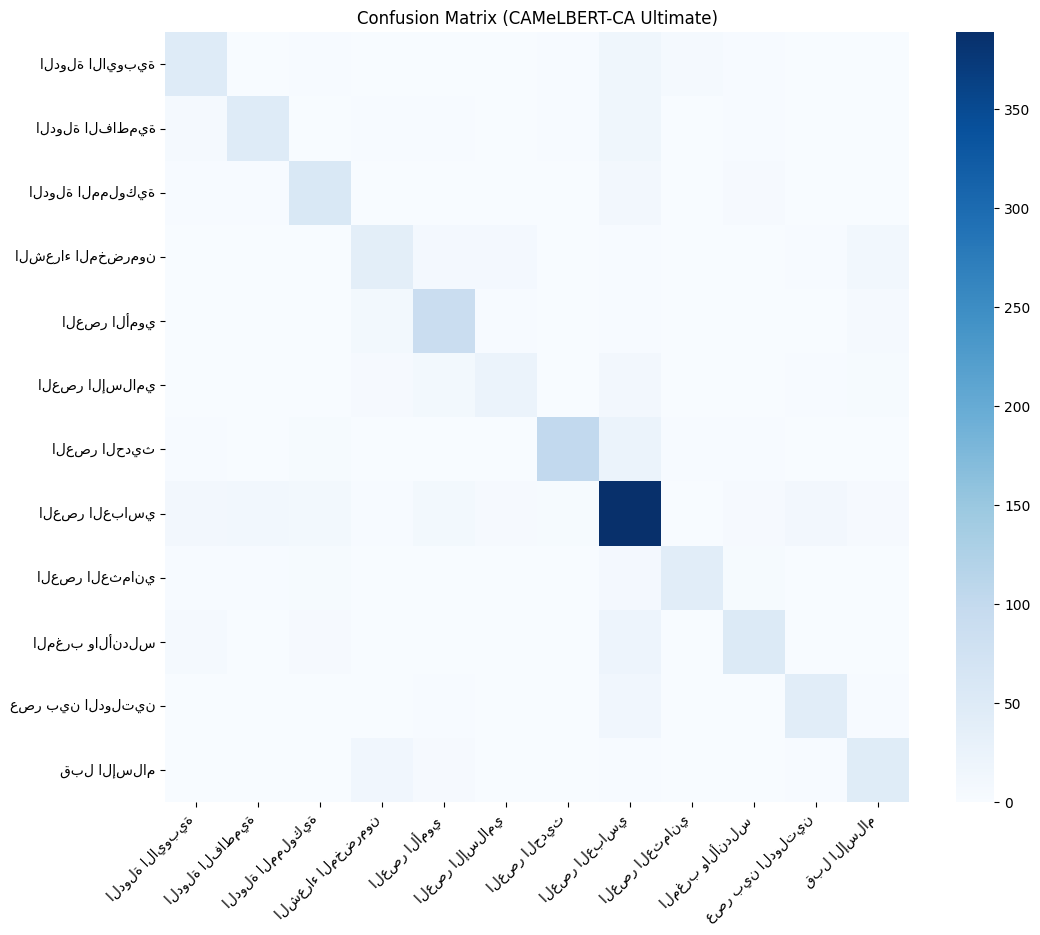

In [ ]:
print("\n Final Report :")
preds_output = trainer.predict(val_ds)
#prediction is in shape of (samples, 12) and converted to argmax(axis=1)
#which means selecting class with highest score
y_pred = np.argmax(preds_output.predictions, axis = 1)
y_true = preds_output.label_ids

#printing text report
print(classification_report(y_true, y_pred, target_names = le.classes_, digits = 3))

#visualizing Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot = False, cmap = "Blues", xticklabels = le.classes_, yticklabels = le.classes_)
plt.title("Confusion Matrix (CAMeLBERT-CA Ultimate)")
plt.xticks(rotation = 45, ha = 'right')
plt.show()

***Save Model and Tokenizer***

In [16]:
save_path = "./camelbert_ultimate_final"
print(f"Saving model to {save_path}...")
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print("Saved successfully.")

Saving model to ./camelbert_ultimate_final...
Saved successfully.
